In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor

### Task 2: Everything is in order

For this task, research and implement the quantum algorithm for order finding. Then, apply it in the larger context of Shor's algorithm, starting from the pseudocode below. Use you algorithm to factor the value  from the previous task.

Shor's algorithm is used to determine the prime factors of an input $N$. It is a classical algorithm which has one step (step 3, below) that should be executed on a quantum computer.

0. Determine if $N$ is even, prime or an integer power of a prime number. If so, we will not use Shor's algorithm. There are efficient classical methods of determining if a given input falls into one of the list categories, and calculating the factors.
1. Select an integer $q$ such that $$ N^2 \leq q < 2N^2 . $$.
2. Pick a random integer $1<a<N$ and calculate the greatest common divisor (gcd) of $a$ and $N$. If the gcd is not equal to one, then $gcd(a,N)$ is a factor of $N$. The other factor would therefore be $N/gcd(a,N)$. In this case, we are done. Otherwise, continue to step 4.
3. Execute the period finding algorithm (see below) to determine $r$.
4. If $r$ is odd, go back to step 2.
5. If $a^{r/2} \equiv -1 \text{ mod } n$ go back to 2.
6. The factors of $N$ are $p,q = \text{gcd}(a^{r/2} \pm 1, N)$

To explain the order finding algorithm, we first describe the quantum Fourier transform.

#### Quantum Fourier transform (QFT)

The QFT is essentially just a change of basis, as described by:

$$ \sum_{j} \alpha_j | j \rangle \rightarrow \sum_{k} \tilde{\alpha}_k | k \rangle $$

where,

$$ | j \rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} e^{2 \pi i j k /N} | k \rangle . $$


#### Period finding algorithm

The problem associated with the period finding algorithm is to determine the smallest integer period $r$ such that $f(x+r) = f(x)$ for $f(x) = a^x \text{ mod } N$. The algorithm is as follows:

1. Prepare the initial state of the system, which consists of two registers of length $l$, where $q=2^l$, in the zero state:
$$ | \Psi_i \rangle = | 0 \rangle_{r_1} | 0 \rangle_{r_2} = | 0 \rangle^{\otimes 2^l} $$
2. Initialize first register ($r_1$) with a superposition of all states.
$$ | \Psi_0 \rangle = H^{\otimes l} \otimes \mathbb{1}^{\otimes l} | 0 \rangle^{\otimes 2l} = \Bigg( \frac{1}{\sqrt{2}} \Big( | 0 \rangle + | 1 \rangle \Big)  \Bigg)^{\otimes l} \otimes | 0 \rangle^{\otimes l} = \frac{1}{\sqrt{q}} \sum_{a = 0}^{q-1} | a \rangle | 0 \rangle^{\otimes l} $$
3. Apply the unitary that implements the function $f = a^x \text{ mod } n$.
$$ | \Psi_1 \rangle = U_f | \Psi_0 \rangle = \frac{1}{\sqrt{q}} \sum_{x = 0}^{q-1} | x \rangle | f(x) \rangle $$
4. Perform the inverse QFT on first register.
5. Perform Measurement of the qubits in the first register.
6. Continued Fraction Expansion to determine $r$.

Our first attempt at implementing the quantum order finding algorithm was following the $\texttt{QISKIT}$ tutorial found [here](https://qiskit.org/textbook/ch-algorithms/shor.html). Unfortunately, we were unable to determine how to implement the modular exponentiation function for $N=91$. The quantum circuit is supposed to be constructed on the single-gate level, and we were unsure how to decompose the modular exponentiation function into $\texttt{SWAP}$ gates.

Our next attempt to implement the quantum order finding algorithm was by using another $\texttt{QISKIT}$ tutorial found [here](https://qiskit.org/documentation/tutorials/algorithms/08_factorizers.html#:~:text=Shor's%20Factoring%20algorithm%C2%B6,N%20%3D%2015%20backend%20%3D%20Aer.). This approach was much simpler computationally, as the functions required to implement the entire algorithm are included in the library package- including the modular exponentiation. Again, our attempts to use this package for the case of $N=91$ failed due to insufficient memory to execute the code. Note that we also experimented with different values of $a$, with no success. Additionally, we verified that the memory issue was not a Jupyter Notebook issue, and found that running the relevant code from the command line also produced the memory error.

![qiskit_memory](../Images/qiskit_memory.PNG)

In [2]:
#N = 91
#backend = Aer.get_backend('aer_simulator')
#quantum_instance = QuantumInstance(backend, shots=1024)
#shor = Shor(quantum_instance=quantum_instance)
#result = shor.factor(N)
#print(f"The list of factors of {N} as computed by the Shor's algorithm is {result.factors[0]}.")

We decided to implement a classical algorithm to solve the order finding problem. This was not the ideal solution, but it was a method to move forward on this task. 

In [3]:
def order_finder(a, N):
    '''
    Function returns order 'r' : a^r = 1 mod N
    Inputs: a, n
    Returns: order 'r'
    '''
    ret_val = -1
    for i in range(1,1000):
        if a**i % 91 == 1:
            ret_val = i
            break
    return ret_val

def shor_factorization(N):
    '''
    Input: int N with unique factorization N = pq
    Returns: p, q of type int
    '''
    p, q = 1, 1
    a = 1 # instead of choosing a random a, we will start at a=2, run the algorithm, and increment a if it fails
    fails = -1
    
    while p*q != N:
        
        if np.gcd(a,N) != 1: # check to see if a and N are co-prime or not
            p = a
            q = int(N/a)
        else:
            r = order_finder(a, N)
            if r == -1:
                pass #print('No order found.')
            if r % 2 == 1:
                pass #print('r is odd : restarting...')
            elif (a**(r/2)%N==1) or (a**(r/2)%N==N-1) :
                pass #print('Factor not found, restarting... ')
            else:
                p = np.gcd(a**int(r/2)+1, N)
                q = np.gcd(a**int(r/2)-1, N)
        fails += 1
        a += 1
    
    return (p,q, a-1, r, fails)

In [4]:
p,q,a,r,fails = shor_factorization(91)
print('a =', a, ', r =', r, ', a^r % 91 =', a**r % 91)
print('p =', p, 'q =', q)

a = 2 , r = 12 , a^r % 91 = 1
p = 13 q = 7


In [5]:
%timeit shor_factorization(91)

13.7 µs ± 503 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


For $N = 91$, our code calculates the factors to be (p,q) = (13,7). Since 13x7=91 and we know that 13 and 7 are both prime, the code produces the correct result. Further, the values of a = 2 and r = 12 yield 2^12 % 91 = 1, which is the desired result.

Our analysis shows that even using a classical order finding method, breaking RSA which uses 7 bit number (91 = 0b1011011) is very easy. It only takes ~15 microseconds to run the (rather unoptimized) code. That's just a 7 bit number though- we should expect that this will get much tougher for larger numbers.

## Task 3: Are we running Shor-t on time?

You will likely have noticed in Task 2 that Shor's algorithm is not guaranteed to find a solution. In fact, there are few potential points of failure. How often does your implementation succeed? How does this depend on the size of ?

Further to this point, now that you have an implementation, let's stress test it. Use Shor's algorithm to factor a sequence of increasingly large . How large of a number can you reliably factor with your computer? As you are increasing , take the opportunity to perform an analysis of:

- Run time (wall time)
- Number of qubits required
- Number of quantum gates required

Present your results graphically and use this to infer the scaling of these resources with the size of the problem instance.

After, consider the following: how does the size of your largest solved instance compare with the size of RSA keys in use today? Can you estimate the quantum resources that would be needed to factor numbers of this size, and when we might have a device capable of doing so? Consider the qubit count and gate count in your estimate. To take things further, you could even estimate a rough wall time by looking at circuit depth, and gate operation speeds of present-day hardware.


In [6]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

def countTotalBits(num):
     
     # convert number into it's binary and
     # remove first two characters 0b.
     binary = bin(num)[2:]
     return len(binary)

In [7]:
decimal_vals = np.arange(2,2**15,1)
binary_vals = np.array([])

for d in decimal_vals:
    binary_vals = np.append(binary_vals, countTotalBits(d))

In [8]:
fail_vals = np.array([])
n_qubits = 2*np.log2(np.array([15,21,35,69,129,511,1011,1027,2049,7909,8193,16387,1073741821]))


for d in decimal_vals[0:2**8]:
    p,q,a,r,fails = shor_factorization(d)
    fail_vals = np.append(fail_vals, fails)

In [9]:
partitioned_N = np.unique(binary_vals)[0:8]
probabilities = np.zeros(len(partitioned_N))
sizes = np.zeros(len(partitioned_N))

for i in range(len(decimal_vals[0:2**8])):
    for j in range(len(partitioned_N)):
        if binary_vals[i] == partitioned_N[j]:
            probabilities[j] += fail_vals[i]
            sizes[j] += 1

for i in range(len(probabilities)):
    probabilities[i] /= sizes[i]

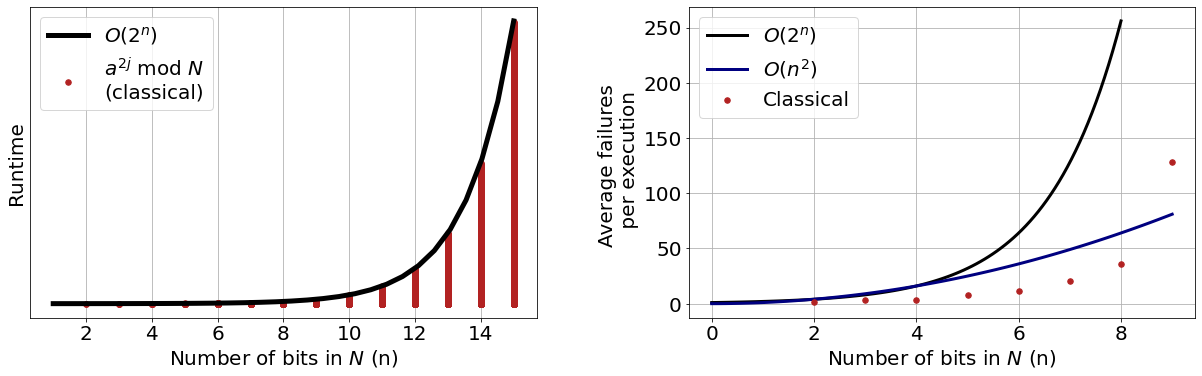

In [10]:
fig, axes = plt.subplots(figsize=(18, 6), nrows=1, ncols=3)
fig.tight_layout(pad=5.0)

plt.subplot(1, 2, 1)
plt.xlabel('Number of bits in $N$ (n)', fontsize=20); plt.ylabel('Runtime', fontsize=20)
plt.plot(np.linspace(1,15,30), 2**np.linspace(1,15,30), lw=5, c='k', label='$O(2^n)$', zorder=5)
plt.scatter(binary_vals, a2jmodN(2,10,decimal_vals), s=30, c='firebrick', label='$a^{2j}$ mod $N$ \n(classical)', zorder=4)
plt.xticks(fontsize=20); plt.yticks([],[],fontsize=20) 
plt.legend(fontsize=20)
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('Number of bits in $N$ (n)', fontsize=20); plt.ylabel('Average failures \n per execution', fontsize=20)
plt.plot(np.linspace(0,8,100), 2**(np.linspace(0,8,100)), c='k', label='$O(2^n)$', zorder=4, lw=3)
plt.plot(np.linspace(0,9,100), np.linspace(0,9,100)**2, c='navy', label='$O(n^2)$', zorder=4, lw=3)
plt.scatter(partitioned_N, probabilities, s=30, c='firebrick', zorder=4, label='Classical')
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)

plt.subplots_adjust(wspace=0.3)
#plt.savefig('shor_comp.PNG')

plt.show()

The plot on the left shows how the runtime (the number operations/cycles/gates) of the modular exponential function scales with the number of input bits. $N$ is the divisor and $n$ is the number of bits when $N$ is represented as a binary. The red data points correspond to the runtime of the modular exponential function as implemented classically in task 2. We see that in the worst case, the algorithm scales as $O(2^n)$, i.e., it is exponential. With quantum modular exponentiation, on the other hand, the number of operations scales as $O(n^3)$ when the quantum circuit has been efficiently implemented.

The plot on the right shows the average numer of failures when Shor's algorithm is implemented using the classical order finding algorithm. The classical implementation actually has fewer failures as compared to the quantum version for $n \leq 8$. Not surprisingly, for values with legnth longer that a byte, the quantum order finding algorithm results in fewer failures.

## References

[1] Van Meter, Rodney, and Kohei M. Itoh. "Fast quantum modular exponentiation." Physical Review A 71.5 (2005): 052320.

In [47]:
d = 32
N = 2**d + 1
print(N)
p,q,a,r,fails = shor_factorization(N)
print('p =', p, ', q =', q)
print('p*q =', p*q)
print(p*q == N)
print(countTotalBits(N))

4294967297
p = 641 , q = 6700417
p*q = 4294967297
True
33


In [48]:
%timeit shor_factorization(N)

1.6 s ± 317 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
